In [1]:
import numpy as np
import pandas as pd
import h5py
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchinfo import summary
from typing import Tuple, Optional
import os 
import torch.utils.checkpoint as checkpoint
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm, trange
import seaborn as sns
import gc
import pywt 
import time 
import time
import warnings
from collections import deque
import psutil
import os
import warnings
import math 
warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
FILE_PATH = "C:\\workarea\\CNN model\\dataset\\radioml2018\\versions\\2\\GOLD_XYZ_OSC.0001_1024.hdf5"
JSON_PATH = 'C:\\workarea\\CNN model\\dataset\\radioml2018\\versions\\2\\classes-fixed.json' 

# Focused experiment setup
TARGET_MODULATIONS = ['8PSK', '16QAM']  # Only 2 modulations
TARGET_SNRS = [-6, 6, 18]  # Low, Medium, High SNR

# Processing settings
OUTPUT_DIR = './focused_cwt_experiment'
TRAIN_RATIO = 0.8
VALID_RATIO = 0.2

patience = 15 

# CWT settings
WAVELET_NAME = 'cmor1.5-1.0'  # Complex Morlet wavelet
NUM_SCALES = 64              # Number of wavelet scales
TARGET_SIZE = 32             # Output image size (32x32)

print(f"🎯 CWT Preprocessing Setup:")
print(f"   Modulations: {TARGET_MODULATIONS}")
print(f"   SNR levels: {TARGET_SNRS}")
print(f"   Wavelet: {WAVELET_NAME}")
print(f"   Scales: {NUM_SCALES}")
print(f"   Output size: {TARGET_SIZE}x{TARGET_SIZE}")
print(f"   Output directory: {OUTPUT_DIR}")

🎯 CWT Preprocessing Setup:
   Modulations: ['8PSK', '16QAM']
   SNR levels: [-6, 6, 18]
   Wavelet: cmor1.5-1.0
   Scales: 64
   Output size: 32x32
   Output directory: ./focused_cwt_experiment


### *DATA LOADING*

In [4]:
def load_and_filter_data():
    """Load RadioML data and filter for target modulations and SNRs."""
    
    print("📂 Loading and filtering RadioML data...")
    
    # Load files
    h5_file = h5py.File(FILE_PATH, 'r')
    with open(JSON_PATH, 'r') as f:
        modulation_classes = json.load(f)
    
    # Load arrays
    X = h5_file['X']  # Shape: (samples, 1024, 2)
    Y = np.argmax(h5_file['Y'], axis=1)  # Labels
    Z = h5_file['Z'][:, 0]  # SNRs
    
    print(f"   Original dataset: {X.shape[0]} samples")
    
    # Get target modulation indices
    target_mod_indices = [modulation_classes.index(mod) for mod in TARGET_MODULATIONS]
    print(f"   Target modulation indices: {dict(zip(TARGET_MODULATIONS, target_mod_indices))}")
    
    # Filter for target modulations and SNRs
    mask = np.zeros(len(Y), dtype=bool)
    sample_counts = {}
    
    for mod_idx in target_mod_indices:
        for snr in TARGET_SNRS:
            condition = (Y == mod_idx) & (Z == snr)
            mask |= condition
            count = np.sum(condition)
            mod_name = TARGET_MODULATIONS[target_mod_indices.index(mod_idx)]
            sample_counts[f"{mod_name}_{snr}dB"] = count
            print(f"   {mod_name} at {snr}dB: {count} samples")
    
    # Apply filter
    X_filtered = X[mask]
    Y_filtered = Y[mask]
    Z_filtered = Z[mask]
    
    # Remap labels to 0, 1 (8PSK=0, 16QAM=1)
    label_mapping = {}
    for new_label, old_label in enumerate(target_mod_indices):
        Y_filtered[Y_filtered == old_label] = new_label
        label_mapping[old_label] = new_label
    
    print(f"✅ Filtered dataset: {X_filtered.shape[0]} samples")
    print(f"   Label mapping: {label_mapping}")
    
    h5_file.close()
    return X_filtered, Y_filtered, Z_filtered, label_mapping, sample_counts

### *CWT FEATURE EXTRACTION METHODS*

In [5]:
def apply_cwt_transform(i_signal, q_signal, scales, wavelet_name):
    """
    Apply complex wavelet transform to I/Q signals.
    
    Args:
        i_signal: In-phase component
        q_signal: Quadrature component  
        scales: Wavelet scales array
        wavelet_name: Wavelet type (e.g., 'cmor1.5-1.0')
        
    Returns:
        magnitude_2d: 32x32 magnitude spectrogram
        phase_2d: 32x32 phase spectrogram
    """
    
    # Combine I/Q into complex signal
    complex_signal = i_signal + 1j * q_signal
    
    # Apply complex wavelet transform
    coefficients, frequencies = pywt.cwt(complex_signal, scales, wavelet_name)
    
    # Extract magnitude and phase
    magnitude = np.abs(coefficients)
    phase = np.angle(coefficients)
    
    # Reshape to target dimensions (32x32)
    magnitude_2d = reshape_to_32x32(magnitude)
    phase_2d = reshape_to_32x32(phase)
    
    return magnitude_2d.astype(np.float32), phase_2d.astype(np.float32)

def reshape_to_32x32(coeffs):
    """
    Reshape wavelet coefficients to exactly 32x32.
    
    Args:
        coeffs: 2D array of shape (num_scales, signal_length)
        
    Returns:
        resized: 32x32 array
    """
    h, w = coeffs.shape
    
    # Calculate downsampling indices
    h_indices = np.linspace(0, h-1, TARGET_SIZE).astype(int)
    w_indices = np.linspace(0, w-1, TARGET_SIZE).astype(int)
    
    # Use advanced indexing for efficient downsampling
    resized = coeffs[np.ix_(h_indices, w_indices)]
    
    # Ensure exactly TARGET_SIZE x TARGET_SIZE
    if resized.shape != (TARGET_SIZE, TARGET_SIZE):
        # Final resize if needed
        result = np.zeros((TARGET_SIZE, TARGET_SIZE), dtype=coeffs.dtype)
        min_h = min(TARGET_SIZE, resized.shape[0])
        min_w = min(TARGET_SIZE, resized.shape[1])
        result[:min_h, :min_w] = resized[:min_h, :min_w]
        return result
    
    return resized

### *PROCESSING PIPELINE*

In [6]:
def preprocess_cwt_dataset():
    """Main CWT preprocessing pipeline."""
    
    # Create output directory
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    # Load and filter data
    X_filtered, Y_filtered, Z_filtered, label_mapping, sample_counts = load_and_filter_data()
    
    total_samples = len(X_filtered)
    print(f"\n🌊 Starting CWT processing for {total_samples} samples...")
    
    # Setup wavelet scales
    signal_length = X_filtered.shape[1]  # Should be 1024
    scales = np.logspace(0, np.log10(signal_length//4), NUM_SCALES)
    
    print(f"   Signal length: {signal_length}")
    print(f"   Scales range: {scales[0]:.1f} to {scales[-1]:.1f}")
    print(f"   Expected time: ~{total_samples * 0.5 / 3600:.1f} hours")
    
    # Process all samples
    start_time = time.time()
    
    magnitude_list = []
    phase_list = []
    labels_list = []
    snrs_list = []
    
    for i in tqdm(range(total_samples), desc="CWT Processing", unit="samples"):
        # Extract I/Q signals
        i_signal = X_filtered[i, :, 0]
        q_signal = X_filtered[i, :, 1]
        
        # Apply CWT transform
        magnitude_2d, phase_2d = apply_cwt_transform(i_signal, q_signal, scales, WAVELET_NAME)
        
        # Store results
        magnitude_list.append(magnitude_2d)
        phase_list.append(phase_2d)
        labels_list.append(Y_filtered[i])
        snrs_list.append(Z_filtered[i])
        
        # Progress update every 1000 samples
        if (i + 1) % 1000 == 0:
            elapsed = time.time() - start_time
            rate = (i + 1) / elapsed
            eta = (total_samples - i - 1) / rate if rate > 0 else 0
            print(f"   Processed {i+1}/{total_samples} samples ({rate:.1f} samples/s, ETA: {eta/3600:.1f}h)")
    
    # Convert to numpy arrays
    magnitudes = np.array(magnitude_list)
    phases = np.array(phase_list)
    labels = np.array(labels_list)
    snrs = np.array(snrs_list)
    
    processing_time = time.time() - start_time
    print(f"✅ CWT processing complete!")
    print(f"   Total time: {processing_time/60:.1f} minutes")
    print(f"   Average speed: {total_samples/processing_time:.1f} samples/second")
    print(f"   Output shapes: magnitude={magnitudes.shape}, phase={phases.shape}")
    
    # Create train/valid splits and save
    create_splits_and_save(magnitudes, phases, labels, snrs, sample_counts)
    
    return magnitudes, phases, labels, snrs

def create_splits_and_save(magnitudes, phases, labels, snrs, sample_counts):
    """Create stratified splits and save to HDF5 files."""
    
    print(f"\n📊 Creating stratified train/validation splits...")
    
    # Stratified split to maintain modulation/SNR balance
    train_indices = []
    valid_indices = []
    
    # Split by modulation and SNR combination
    for mod_label in [0, 1]:  # 8PSK=0, 16QAM=1
        for snr in TARGET_SNRS:
            # Find samples for this combination
            mask = (labels == mod_label) & (snrs == snr)
            indices = np.where(mask)[0]
            
            # Shuffle and split
            np.random.shuffle(indices)
            split_point = int(TRAIN_RATIO * len(indices))
            
            train_indices.extend(indices[:split_point])
            valid_indices.extend(indices[split_point:])
            
            mod_name = TARGET_MODULATIONS[mod_label]
            print(f"   {mod_name} @ {snr}dB: {split_point} train, {len(indices)-split_point} valid")
    
    train_indices = np.array(train_indices)
    valid_indices = np.array(valid_indices)
    
    print(f"✅ Split created:")
    print(f"   Train samples: {len(train_indices)}")
    print(f"   Valid samples: {len(valid_indices)}")
    
    # Save splits
    save_split('train', train_indices, magnitudes, phases, labels, snrs)
    save_split('valid', valid_indices, magnitudes, phases, labels, snrs)

def save_split(split_name, indices, magnitudes, phases, labels, snrs):
    """Save a data split to HDF5 file."""
    
    output_file = os.path.join(OUTPUT_DIR, f'{split_name}_cwt.h5')
    print(f"💾 Saving {split_name} split to {output_file}...")
    
    with h5py.File(output_file, 'w') as f:
        # Save data arrays
        f.create_dataset('magnitudes', data=magnitudes[indices], compression='gzip', compression_opts=6)
        f.create_dataset('phases', data=phases[indices], compression='gzip', compression_opts=6)
        f.create_dataset('labels', data=labels[indices])
        f.create_dataset('snrs', data=snrs[indices])
        
        # Save metadata
        f.attrs['num_samples'] = len(indices)
        f.attrs['num_classes'] = 2
        f.attrs['wavelet_name'] = WAVELET_NAME
        f.attrs['num_scales'] = NUM_SCALES
        f.attrs['target_size'] = TARGET_SIZE
        f.attrs['modulations'] = [mod.encode('utf-8') for mod in TARGET_MODULATIONS]
        f.attrs['target_snrs'] = TARGET_SNRS
        f.attrs['split'] = split_name
    
    file_size = os.path.getsize(output_file) / (1024**2)  # MB
    print(f"   File size: {file_size:.1f} MB")

In [7]:
def visualize_cwt_samples():
    """Visualize CWT samples - ensure both modulations are shown."""
    
    print(f"\n🔍 Visualizing CWT samples...")
    
    train_file = os.path.join(OUTPUT_DIR, 'train_cwt.h5')
    
    with h5py.File(train_file, 'r') as f:
        magnitudes = f['magnitudes'][:]
        phases = f['phases'][:]
        labels = f['labels'][:]
        snrs = f['snrs'][:]
    
    # Sample 3 from each modulation (8PSK and 16QAM)
    samples_to_show = []
    
    # Get 3 samples of 8PSK (label=0)
    psk_indices = np.where(labels == 0)[0][:3]
    samples_to_show.extend(psk_indices)
    
    # Get 3 samples of 16QAM (label=1)
    qam_indices = np.where(labels == 1)[0][:3]
    samples_to_show.extend(qam_indices)
    
    # Create visualization
    fig, axes = plt.subplots(2, 6, figsize=(18, 6))
    
    for i, sample_idx in enumerate(samples_to_show):
        mod_name = TARGET_MODULATIONS[labels[sample_idx]]
        snr = snrs[sample_idx]
        
        # Magnitude spectrogram
        axes[0, i].imshow(magnitudes[sample_idx], aspect='auto', cmap='viridis')
        axes[0, i].set_title(f'Magnitude\n{mod_name} ({snr:.0f}dB)')
        
        # Phase spectrogram
        axes[1, i].imshow(phases[sample_idx], aspect='auto', cmap='hsv')
        axes[1, i].set_title(f'Phase\n{mod_name} ({snr:.0f}dB)')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Showing 3 samples each of 8PSK and 16QAM")

def print_final_summary():
    """Print final preprocessing summary."""
    
    print(f"\n📋 CWT Preprocessing Summary:")
    print(f"   Method: Complex Wavelet Transform")
    print(f"   Wavelet: {WAVELET_NAME}")
    print(f"   Scales: {NUM_SCALES}")
    print(f"   Output size: {TARGET_SIZE}×{TARGET_SIZE}")
    print(f"   Modulations: {TARGET_MODULATIONS}")
    print(f"   SNR levels: {TARGET_SNRS}")
    
    # Check file sizes
    for split in ['train', 'valid']:
        file_path = os.path.join(OUTPUT_DIR, f'{split}_cwt.h5')
        if os.path.exists(file_path):
            with h5py.File(file_path, 'r') as f:
                num_samples = f.attrs['num_samples']
                file_size = os.path.getsize(file_path) / (1024**2)
                
                print(f"\n   {split.capitalize()} dataset:")
                print(f"     Samples: {num_samples}")
                print(f"     File size: {file_size:.1f} MB")
                
                # Class distribution
                labels = f['labels'][:]
                snrs = f['snrs'][:]
                
                for mod_idx, mod_name in enumerate(TARGET_MODULATIONS):
                    for snr in TARGET_SNRS:
                        count = np.sum((labels == mod_idx) & (snrs == snr))
                        print(f"     {mod_name} @ {snr}dB: {count} samples")
    
    print(f"\n✅ Ready for training!")
    print(f"   Use files: {OUTPUT_DIR}/train_cwt.h5 and {OUTPUT_DIR}/valid_cwt.h5")

In [8]:
magnitudes, phases, labels, snrs = preprocess_cwt_dataset()

📂 Loading and filtering RadioML data...
   Original dataset: 2555904 samples
   Target modulation indices: {'8PSK': 5, '16QAM': 12}
   8PSK at -6dB: 4096 samples
   8PSK at 6dB: 4096 samples
   8PSK at 18dB: 4096 samples
   16QAM at -6dB: 4096 samples
   16QAM at 6dB: 4096 samples
   16QAM at 18dB: 4096 samples
✅ Filtered dataset: 24576 samples
   Label mapping: {5: 0, 12: 1}

🌊 Starting CWT processing for 24576 samples...
   Signal length: 1024
   Scales range: 1.0 to 256.0
   Expected time: ~3.4 hours


CWT Processing:   4%|██▎                                                    | 1014/24576 [00:08<03:20, 117.66samples/s]

   Processed 1000/24576 samples (115.4 samples/s, ETA: 0.1h)


CWT Processing:   8%|████▌                                                  | 2017/24576 [00:17<03:22, 111.64samples/s]

   Processed 2000/24576 samples (118.2 samples/s, ETA: 0.1h)


CWT Processing:  12%|██████▋                                                | 3010/24576 [00:24<02:39, 135.39samples/s]

   Processed 3000/24576 samples (124.0 samples/s, ETA: 0.0h)


CWT Processing:  16%|████████▉                                              | 4014/24576 [00:31<02:19, 146.88samples/s]

   Processed 4000/24576 samples (127.7 samples/s, ETA: 0.0h)


CWT Processing:  20%|███████████▎                                           | 5029/24576 [00:38<02:24, 135.60samples/s]

   Processed 5000/24576 samples (129.9 samples/s, ETA: 0.0h)


CWT Processing:  24%|█████████████▍                                         | 6019/24576 [00:46<02:08, 144.93samples/s]

   Processed 6000/24576 samples (130.4 samples/s, ETA: 0.0h)


CWT Processing:  29%|███████████████▋                                       | 7021/24576 [00:53<02:12, 132.17samples/s]

   Processed 7000/24576 samples (131.7 samples/s, ETA: 0.0h)


CWT Processing:  33%|█████████████████▉                                     | 8030/24576 [01:00<01:52, 147.05samples/s]

   Processed 8000/24576 samples (132.3 samples/s, ETA: 0.0h)


CWT Processing:  37%|████████████████████▏                                  | 9016/24576 [01:07<01:44, 148.68samples/s]

   Processed 9000/24576 samples (132.7 samples/s, ETA: 0.0h)


CWT Processing:  41%|██████████████████████                                | 10013/24576 [01:15<01:56, 125.46samples/s]

   Processed 10000/24576 samples (133.0 samples/s, ETA: 0.0h)


CWT Processing:  45%|████████████████████████▏                             | 11019/24576 [01:22<01:32, 146.30samples/s]

   Processed 11000/24576 samples (133.8 samples/s, ETA: 0.0h)


CWT Processing:  49%|██████████████████████████▍                           | 12014/24576 [01:29<01:23, 150.59samples/s]

   Processed 12000/24576 samples (134.1 samples/s, ETA: 0.0h)


CWT Processing:  53%|████████████████████████████▌                         | 13025/24576 [01:36<01:20, 143.87samples/s]

   Processed 13000/24576 samples (134.8 samples/s, ETA: 0.0h)


CWT Processing:  57%|██████████████████████████████▊                       | 14013/24576 [01:43<01:14, 142.73samples/s]

   Processed 14000/24576 samples (134.9 samples/s, ETA: 0.0h)


CWT Processing:  61%|█████████████████████████████████                     | 15023/24576 [01:50<01:05, 146.37samples/s]

   Processed 15000/24576 samples (135.4 samples/s, ETA: 0.0h)


CWT Processing:  65%|███████████████████████████████████▏                  | 16023/24576 [01:57<00:57, 148.89samples/s]

   Processed 16000/24576 samples (135.9 samples/s, ETA: 0.0h)


CWT Processing:  69%|█████████████████████████████████████▍                | 17010/24576 [02:04<00:50, 149.28samples/s]

   Processed 17000/24576 samples (136.3 samples/s, ETA: 0.0h)


CWT Processing:  73%|███████████████████████████████████████▌              | 18027/24576 [02:11<00:45, 142.72samples/s]

   Processed 18000/24576 samples (136.9 samples/s, ETA: 0.0h)


CWT Processing:  77%|█████████████████████████████████████████▊            | 19023/24576 [02:18<00:38, 145.55samples/s]

   Processed 19000/24576 samples (137.4 samples/s, ETA: 0.0h)


CWT Processing:  81%|████████████████████████████████████████████▊          | 20017/24576 [02:26<00:54, 84.06samples/s]

   Processed 20000/24576 samples (136.3 samples/s, ETA: 0.0h)


CWT Processing:  85%|███████████████████████████████████████████████        | 21007/24576 [02:38<00:45, 78.57samples/s]

   Processed 21000/24576 samples (132.3 samples/s, ETA: 0.0h)


CWT Processing:  90%|████████████████████████████████████████████████▎     | 22010/24576 [02:49<00:24, 103.85samples/s]

   Processed 22000/24576 samples (129.7 samples/s, ETA: 0.0h)


CWT Processing:  94%|██████████████████████████████████████████████████▌   | 23010/24576 [02:57<00:12, 124.66samples/s]

   Processed 23000/24576 samples (129.6 samples/s, ETA: 0.0h)


CWT Processing:  98%|████████████████████████████████████████████████████▊ | 24026/24576 [03:05<00:04, 134.30samples/s]

   Processed 24000/24576 samples (129.8 samples/s, ETA: 0.0h)


CWT Processing: 100%|██████████████████████████████████████████████████████| 24576/24576 [03:08<00:00, 130.28samples/s]


✅ CWT processing complete!
   Total time: 3.1 minutes
   Average speed: 130.2 samples/second
   Output shapes: magnitude=(24576, 32, 32), phase=(24576, 32, 32)

📊 Creating stratified train/validation splits...
   8PSK @ -6dB: 3276 train, 820 valid
   8PSK @ 6dB: 3276 train, 820 valid
   8PSK @ 18dB: 3276 train, 820 valid
   16QAM @ -6dB: 3276 train, 820 valid
   16QAM @ 6dB: 3276 train, 820 valid
   16QAM @ 18dB: 3276 train, 820 valid
✅ Split created:
   Train samples: 19656
   Valid samples: 4920
💾 Saving train split to ./focused_cwt_experiment\train_cwt.h5...
   File size: 140.0 MB
💾 Saving valid split to ./focused_cwt_experiment\valid_cwt.h5...
   File size: 35.1 MB



🔍 Visualizing CWT samples...


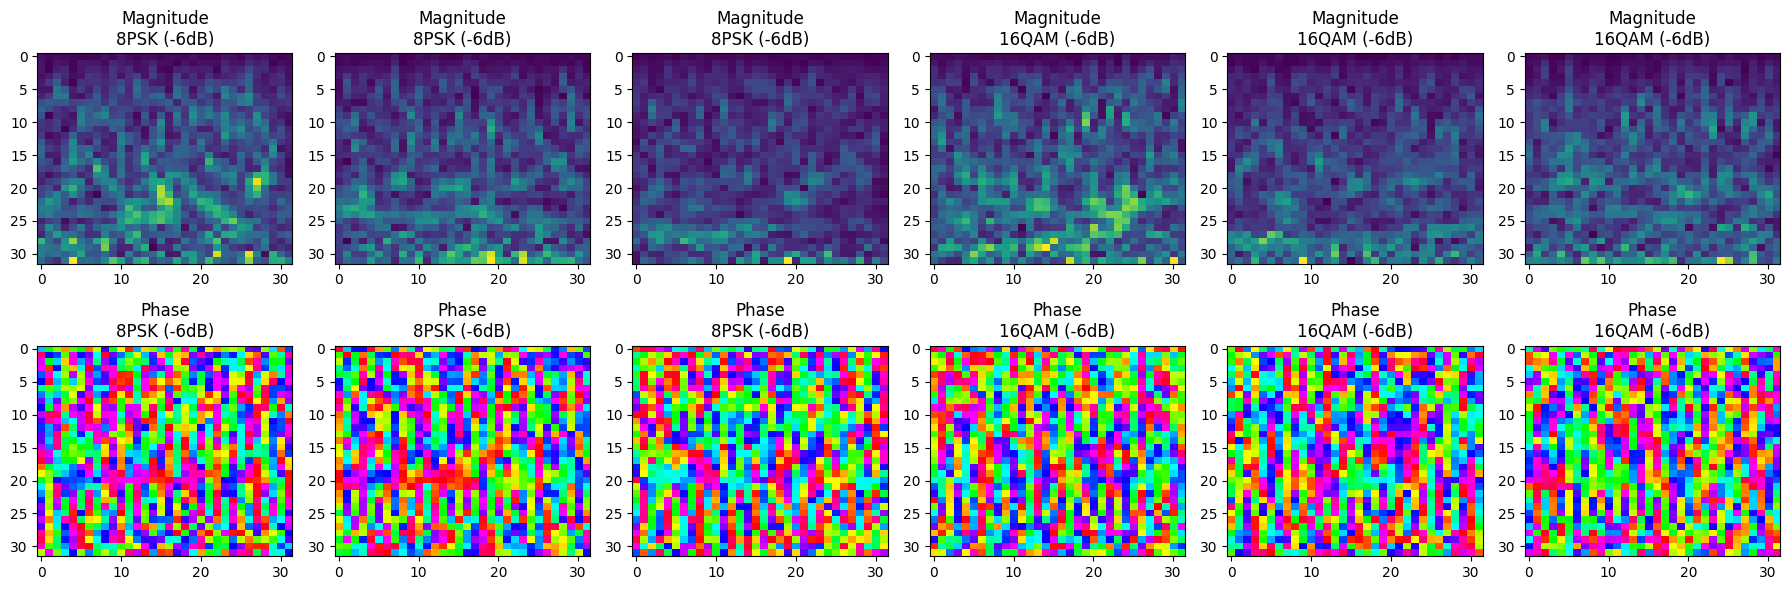

✅ Showing 3 samples each of 8PSK and 16QAM


In [9]:
visualize_cwt_samples()

In [4]:
print_final_summary()

NameError: name 'print_final_summary' is not defined

In [23]:
DATA_DIR = './focused_cwt_experiment'
BATCH_SIZE = 128
NUM_EPOCHS = 300 
NUM_WORKERS = 0 
NUM_CLASSES = len(TARGET_MODULATIONS)
LEARNING_RATE = 0.00015

In [24]:
class CWTDataset(Dataset):
    """Simple dataset class for loading preprocessed CWT magnitude/phase data."""
    
    def __init__(self, h5_file_path, seed=48):
        """
        Initialize CWT dataset.
        
        Args:
            h5_file_path: Path to HDF5 file (e.g., 'train_cwt.h5')
            seed: Random seed (for compatibility with your existing code)
        """
        self.file_path = h5_file_path
        self.seed = seed
        
        if not os.path.exists(h5_file_path):
            raise FileNotFoundError(f"HDF5 file not found: {h5_file_path}")
        
        # Open HDF5 file
        self.h5_file = h5py.File(h5_file_path, 'r')
        
        # Get dataset references
        self.magnitudes = self.h5_file['magnitudes']
        self.phases = self.h5_file['phases']
        self.labels = self.h5_file['labels']
        self.snrs = self.h5_file['snrs']
        
        # Store dataset size
        self.num_samples = self.magnitudes.shape[0]
        
    def __len__(self):
        """Return number of samples."""
        return self.num_samples
    
    def __getitem__(self, idx):
        """
        Get a single sample.
        
        Returns:
            magnitude: (1, 32, 32) tensor - magnitude spectrogram
            phase: (1, 32, 32) tensor - phase spectrogram  
            label: int - modulation class (0=8PSK, 1=16QAM)
            snr: float - signal-to-noise ratio
        """
        if idx < 0 or idx >= self.num_samples:
            raise IndexError(f"Index {idx} out of range for dataset of size {self.num_samples}")
        
        # Load from HDF5
        magnitude = self.magnitudes[idx]
        phase = self.phases[idx]
        label = int(self.labels[idx])
        snr = float(self.snrs[idx])
        
        # Convert to PyTorch tensors and add channel dimension
        magnitude_tensor = torch.from_numpy(magnitude).float().unsqueeze(0)  # (1, 32, 32)
        phase_tensor = torch.from_numpy(phase).float().unsqueeze(0)  # (1, 32, 32)
        
        return magnitude_tensor, phase_tensor, label, snr
    
    def close(self):
        """Close HDF5 file handle."""
        if hasattr(self, 'h5_file') and self.h5_file:
            self.h5_file.close()
    
    def __del__(self):
        """Ensure file cleanup on deletion."""
        self.close()

In [25]:
train_dataset = CWTDataset(
    h5_file_path=os.path.join(DATA_DIR, 'train_cwt.h5'),
    seed=48
)

valid_dataset = CWTDataset(
    h5_file_path=os.path.join(DATA_DIR, 'valid_cwt.h5'),
    seed=48
)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
    pin_memory=True, num_workers=0, persistent_workers=False
)

valid_loader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False, 
    pin_memory=True, num_workers=0, persistent_workers=False
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")

Train dataset size: 19656
Validation dataset size: 4920


In [26]:
# Model 1: Standard CNN-LSTM
try:
    from models.CNN_LSTM_IQ import create_enhanced_CNNLSTMIQModel
    model_standard = create_enhanced_CNNLSTMIQModel(n_labels=NUM_CLASSES, dropout_rate=0.3).to(device)
    print("✅ Successfully built Standard CNN-LSTM Model")
except Exception as e:
    print(f"⚠️ Could not build Standard Model: {e}")

# Model 2: Parallel CNN-LSTM
try:
    from models.CNN_LSTM_IQ_Parallel import create_diagram_iq_model
    model_parallel = create_diagram_iq_model(n_labels=NUM_CLASSES, dropout_rate=0.3).to(device)
    print("✅ Successfully built Parallel CNN-LSTM Model")
except Exception as e:
    print(f"⚠️ Could not build Parallel Model: {e}")

✅ Successfully built Standard CNN-LSTM Model
✅ Successfully built Parallel CNN-LSTM Model


In [27]:
# Shared training components
criterion = nn.CrossEntropyLoss(label_smoothing=0.2).to(device)

optimizer_standard = optim.Adam(model_standard.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
optimizer_parallel = optim.Adam(model_parallel.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

scheduler_standard = optim.lr_scheduler.ReduceLROnPlateau(optimizer_standard, mode='max', factor=0.5, patience=5)
scheduler_parallel = optim.lr_scheduler.ReduceLROnPlateau(optimizer_parallel, mode='max', factor=0.5, patience=5)

scaler_standard = GradScaler()
scaler_parallel = GradScaler()

In [28]:
# --- Training Metrics Storage ---
metrics = {
    'standard': {
        'train_losses': [], 'valid_losses': [], 
        'train_accuracies': [], 'valid_accuracies': [],
        'training_times': [], 'best_accuracy': 0.0,
        'final_predictions': [], 'final_true_labels': []
    },
    'parallel': {
        'train_losses': [], 'valid_losses': [], 
        'train_accuracies': [], 'valid_accuracies': [],
        'training_times': [], 'best_accuracy': 0.0,
        'final_predictions': [], 'final_true_labels': []
    }
}

In [29]:
# Early stopping
patience_counters = {'standard': 0, 'parallel': 0}
best_models = {'standard': None, 'parallel': None}

In [30]:
def train_epoch(model, train_loader, optimizer, criterion, scaler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for magnitude, phase, labels, _ in train_loader:
        magnitude, phase, labels = magnitude.to(device), phase.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        with autocast():
            outputs = model(magnitude, phase)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total
    
    return epoch_loss, epoch_accuracy

def validate_epoch(model, valid_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for magnitude, phase, labels, _ in valid_loader:
            magnitude, phase, labels = magnitude.to(device), phase.to(device), labels.to(device)
            
            outputs = model(magnitude, phase)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(valid_loader)
    epoch_accuracy = 100. * correct / total
    
    return epoch_loss, epoch_accuracy

### *DEBUGGING THE TRAINING PROCESS*

In [31]:
print("model_standard exists:", 'model_standard' in locals())
print("model_parallel exists:", 'model_parallel' in locals()) 
print("train_loader exists:", 'train_loader' in locals())
print("valid_loader exists:", 'valid_loader' in locals())

model_standard exists: True
model_parallel exists: True
train_loader exists: True
valid_loader exists: True


In [32]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Valid dataset size: {len(valid_dataset)}")

Train dataset size: 19656
Valid dataset size: 4920


In [33]:
# Check CUDA status:
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {device}")
print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f}GB")

CUDA available: True
Device: cuda
GPU memory: 17.1GB


In [34]:
# Check model devices:
print(f"Standard model device: {next(model_standard.parameters()).device}")
print(f"Parallel model device: {next(model_parallel.parameters()).device}")

Standard model device: cuda:0
Parallel model device: cuda:0


In [35]:
# Test this first:
print("Testing first batch...")
magnitude, phase, labels, snrs = next(iter(train_loader))
print(f"✅ First batch loaded: {magnitude.shape}")

Testing first batch...
✅ First batch loaded: torch.Size([128, 1, 32, 32])


In [36]:
# Test if models can actually process a batch:
print("Testing forward pass...")

magnitude, phase, labels, snrs = next(iter(train_loader))
magnitude, phase, labels = magnitude.to(device), phase.to(device), labels.to(device)

print(f"Input shapes: {magnitude.shape}, {phase.shape}")

# Test standard model
try:
    with torch.no_grad():
        output_std = model_standard(magnitude, phase)
    print(f"✅ Standard model output: {output_std.shape}")
except Exception as e:
    print(f"❌ Standard model failed: {e}")

# Test parallel model  
try:
    with torch.no_grad():
        output_par = model_parallel(magnitude, phase)
    print(f"✅ Parallel model output: {output_par.shape}")
except Exception as e:
    print(f"❌ Parallel model failed: {e}")

Testing forward pass...
Input shapes: torch.Size([128, 1, 32, 32]), torch.Size([128, 1, 32, 32])
✅ Standard model output: torch.Size([128, 2])
✅ Parallel model output: torch.Size([128, 2])


In [37]:
# Test one complete training step:
print("Testing single training step...")

magnitude, phase, labels, snrs = next(iter(train_loader))
magnitude, phase, labels = magnitude.to(device), phase.to(device), labels.to(device)

# Test standard model training step
try:
    print("Testing standard model step...")
    optimizer_standard.zero_grad()
    
    with autocast():
        outputs = model_standard(magnitude, phase)
        loss = criterion(outputs, labels)
    print(f"Loss computed: {loss.item()}")
    
    scaler_standard.scale(loss).backward()
    print("Backward pass complete")
    
    scaler_standard.unscale_(optimizer_standard)
    scaler_standard.step(optimizer_standard)
    scaler_standard.update()
    print("✅ Standard model step complete")
    
except Exception as e:
    print(f"❌ Standard model step failed: {e}")

Testing single training step...
Testing standard model step...
Loss computed: 12.78258228302002
Backward pass complete
✅ Standard model step complete


In [38]:
# Test simplified training loop without tqdm:
print("Testing simple training loop...")

model_standard.train()
epoch_losses = []

for batch_idx, (magnitude, phase, labels, snrs) in enumerate(train_loader):
    print(f"Processing batch {batch_idx+1}")
    
    magnitude, phase, labels = magnitude.to(device), phase.to(device), labels.to(device)
    
    optimizer_standard.zero_grad()
    
    with autocast():
        outputs = model_standard(magnitude, phase)
        loss = criterion(outputs, labels)
    
    scaler_standard.scale(loss).backward()
    scaler_standard.unscale_(optimizer_standard)
    scaler_standard.step(optimizer_standard)
    scaler_standard.update()
    
    epoch_losses.append(loss.item())
    
    # Stop after 3 batches for testing
    if batch_idx >= 2:
        print(f"✅ Processed {batch_idx+1} batches successfully")
        break

print(f"Average loss: {np.mean(epoch_losses):.4f}")

Testing simple training loop...
Processing batch 1
Processing batch 2
Processing batch 3
✅ Processed 3 batches successfully
Average loss: 11.7327


### Training PRocess

In [39]:
print(f"\n🚀 Starting dual model training...")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    print(f"\n📊 Epoch {epoch+1}/{NUM_EPOCHS}")
    epoch_start = time.time() 
    # Train standard model
    print("   Training standard model...")
    train_loss_std, train_acc_std = train_epoch(
        model_standard, train_loader, optimizer_standard, criterion, scaler_standard, device
    )
    print(f"   ✅ Standard - Train Loss: {train_loss_std:.4f}, Acc: {train_acc_std:.2f}%")
    
    # Train parallel model  
    print("   Training parallel model...")
    train_loss_par, train_acc_par = train_epoch(
        model_parallel, train_loader, optimizer_parallel, criterion, scaler_parallel, device
    )
    print(f"   ✅ Parallel - Train Loss: {train_loss_par:.4f}, Acc: {train_acc_par:.2f}%")
    
    # Validation
    print("   Validating...")
    valid_loss_std, valid_acc_std = validate_epoch(model_standard, valid_loader, criterion, device)
    valid_loss_par, valid_acc_par = validate_epoch(model_parallel, valid_loader, criterion, device)
    
    print(f"   📈 Standard Valid: {valid_acc_std:.2f}% | Parallel Valid: {valid_acc_par:.2f}%")
    
    metrics['standard']['train_losses'].append(train_loss_std)
    metrics['standard']['train_accuracies'].append(train_acc_std)
    metrics['standard']['valid_losses'].append(valid_loss_std)
    metrics['standard']['valid_accuracies'].append(valid_acc_std)
    
    metrics['parallel']['train_losses'].append(train_loss_par)
    metrics['parallel']['train_accuracies'].append(train_acc_par)
    metrics['parallel']['valid_losses'].append(valid_loss_par)
    metrics['parallel']['valid_accuracies'].append(valid_acc_par)
    
    scheduler_standard.step(valid_acc_std)
    scheduler_parallel.step(valid_acc_par)
    
    if valid_acc_std > metrics['standard']['best_accuracy']:
        metrics['standard']['best_accuracy'] = valid_acc_std
        metrics['standard']['patience_counter'] = 0
        torch.save(model_standard.state_dict(), 'best_standard_model.pth')
    else:
        metrics['standard']['patience_counter'] += 1
    
    if valid_acc_par > metrics['parallel']['best_accuracy']:
        metrics['parallel']['best_accuracy'] = valid_acc_par
        metrics['parallel']['patience_counter'] = 0
        torch.save(model_parallel.state_dict(), 'best_parallel_model.pth')
    else:
        metrics['parallel']['patience_counter'] += 1
    
    epoch_time = time.time() - epoch_start
    
    if (epoch + 1) % 5 == 0:
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} ({epoch_time:.2f}s):")
        print(f"Standard  - Train: {train_acc_std:.2f}% | Valid: {valid_acc_std:.2f}% | Loss: {valid_loss_std:.4f}")
        print(f"Parallel  - Train: {train_acc_par:.2f}% | Valid: {valid_acc_par:.2f}% | Loss: {valid_loss_par:.4f}")
        print(f"Best - Standard: {metrics['standard']['best_accuracy']:.2f}% | Parallel: {metrics['parallel']['best_accuracy']:.2f}%")
    
    if min(metrics['standard']['patience_counter'], metrics['parallel']['patience_counter']) >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print(f"\n🎉 Training Complete!")
print(f"Standard Model Best: {metrics['standard']['best_accuracy']:.2f}%")
print(f"Parallel Model Best: {metrics['parallel']['best_accuracy']:.2f}%")

if metrics['standard']['best_accuracy'] > metrics['parallel']['best_accuracy']:
    winner = "Standard"
    margin = metrics['standard']['best_accuracy'] - metrics['parallel']['best_accuracy']
else:
    winner = "Parallel"
    margin = metrics['parallel']['best_accuracy'] - metrics['standard']['best_accuracy']

print(f"🏆 Winner: {winner} model (+{margin:.2f}%)")


🚀 Starting dual model training...

📊 Epoch 1/300
   Training standard model...
   ✅ Standard - Train Loss: 8.3845, Acc: 49.90%
   Training parallel model...
   ✅ Parallel - Train Loss: 0.6935, Acc: 49.15%
   Validating...
   📈 Standard Valid: 49.51% | Parallel Valid: 50.00%

📊 Epoch 2/300
   Training standard model...
   ✅ Standard - Train Loss: 5.0446, Acc: 49.75%
   Training parallel model...
   ✅ Parallel - Train Loss: 0.6932, Acc: 50.23%
   Validating...
   📈 Standard Valid: 50.10% | Parallel Valid: 50.00%

📊 Epoch 3/300
   Training standard model...
   ✅ Standard - Train Loss: 3.8070, Acc: 49.63%
   Training parallel model...
   ✅ Parallel - Train Loss: 0.6931, Acc: 50.67%
   Validating...
   📈 Standard Valid: 49.19% | Parallel Valid: 50.35%

📊 Epoch 4/300
   Training standard model...
   ✅ Standard - Train Loss: 3.4368, Acc: 49.55%
   Training parallel model...
   ✅ Parallel - Train Loss: 0.6929, Acc: 51.00%
   Validating...
   📈 Standard Valid: 49.96% | Parallel Valid: 51.87%



KeyboardInterrupt: 

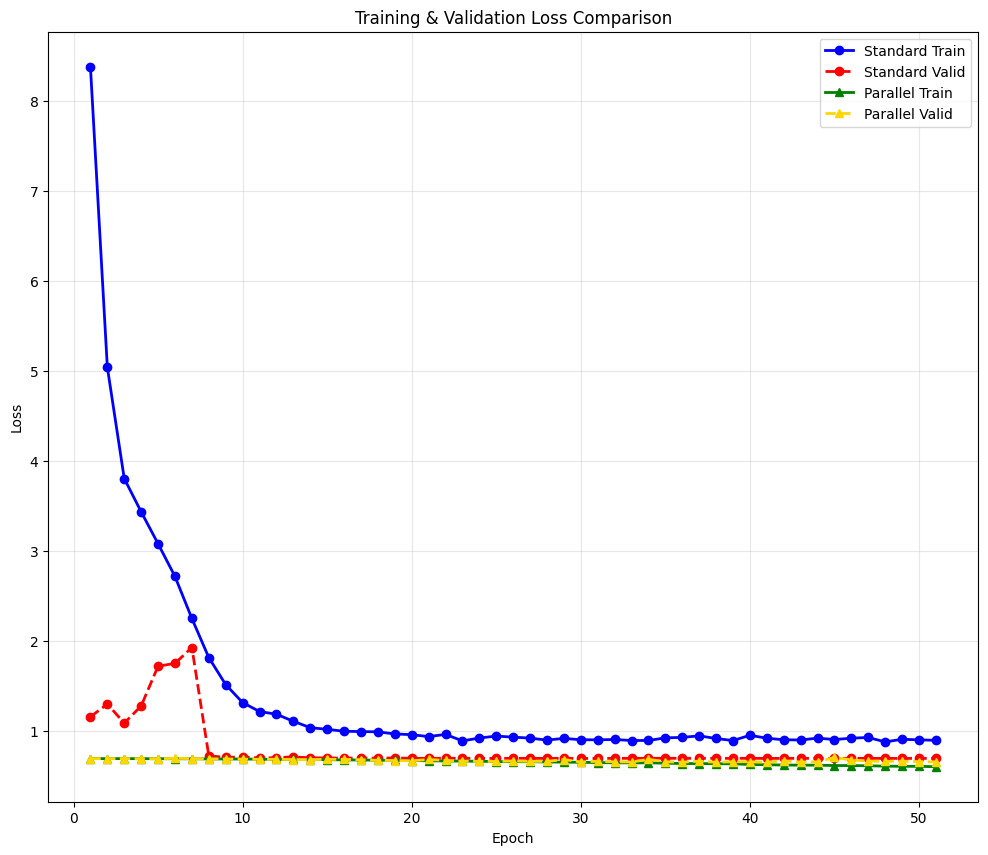

In [40]:
plt.figure(figsize=(12, 10), dpi=100)
epochs = range(1, len(metrics['standard']['train_losses']) + 1)
plt.plot(epochs, metrics['standard']['train_losses'], 'b-', label='Standard Train', linewidth=2,marker = 'o', color = 'blue')
plt.plot(epochs, metrics['standard']['valid_losses'], 'b--', label='Standard Valid', linewidth=2, marker = 'o', color = 'red')
plt.plot(epochs, metrics['parallel']['train_losses'], 'r-', label='Parallel Train', linewidth=2, marker = '^', color = 'green')
plt.plot(epochs, metrics['parallel']['valid_losses'], 'r--', label='Parallel Valid', linewidth=2,marker = '^', color = 'gold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

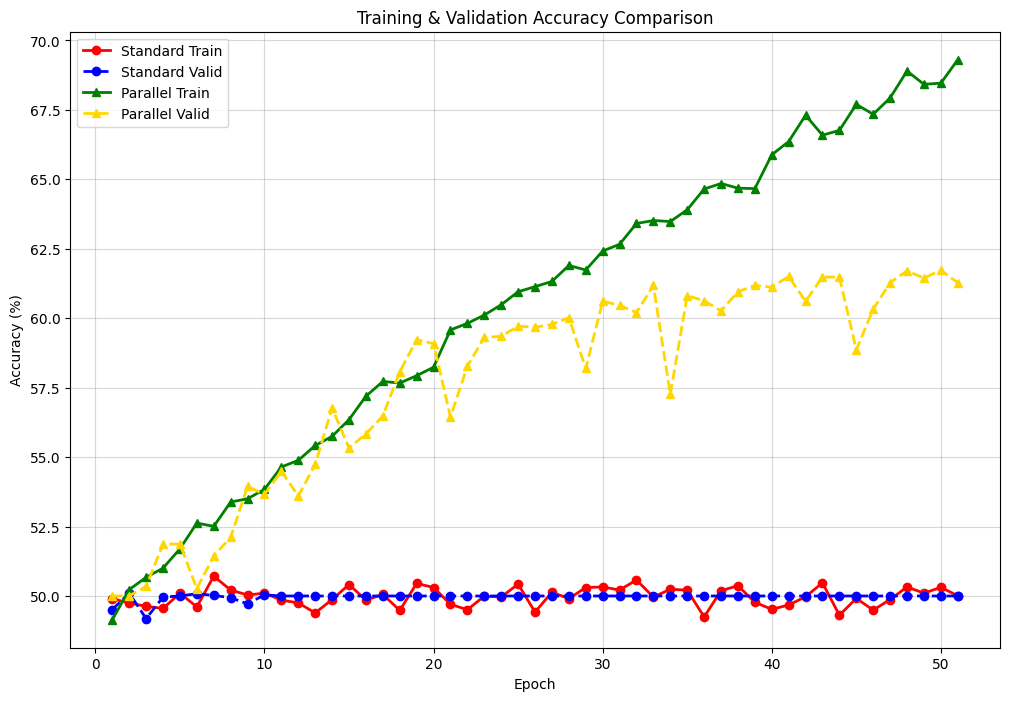

In [41]:
plt.figure(figsize=(12, 8), dpi=100)
plt.plot(epochs, metrics['standard']['train_accuracies'], 'b-', label='Standard Train', linewidth=2,color = 'red',marker = 'o')
plt.plot(epochs, metrics['standard']['valid_accuracies'], 'b--', label='Standard Valid', linewidth=2,color = 'blue', marker = 'o')
plt.plot(epochs, metrics['parallel']['train_accuracies'], 'r-', label='Parallel Train', linewidth=2,color = 'green', marker = '^')
plt.plot(epochs, metrics['parallel']['valid_accuracies'], 'r--', label='Parallel Valid', linewidth=2, color = 'gold', marker = '^')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training & Validation Accuracy Comparison')
plt.legend()
plt.grid(True, alpha=0.5)

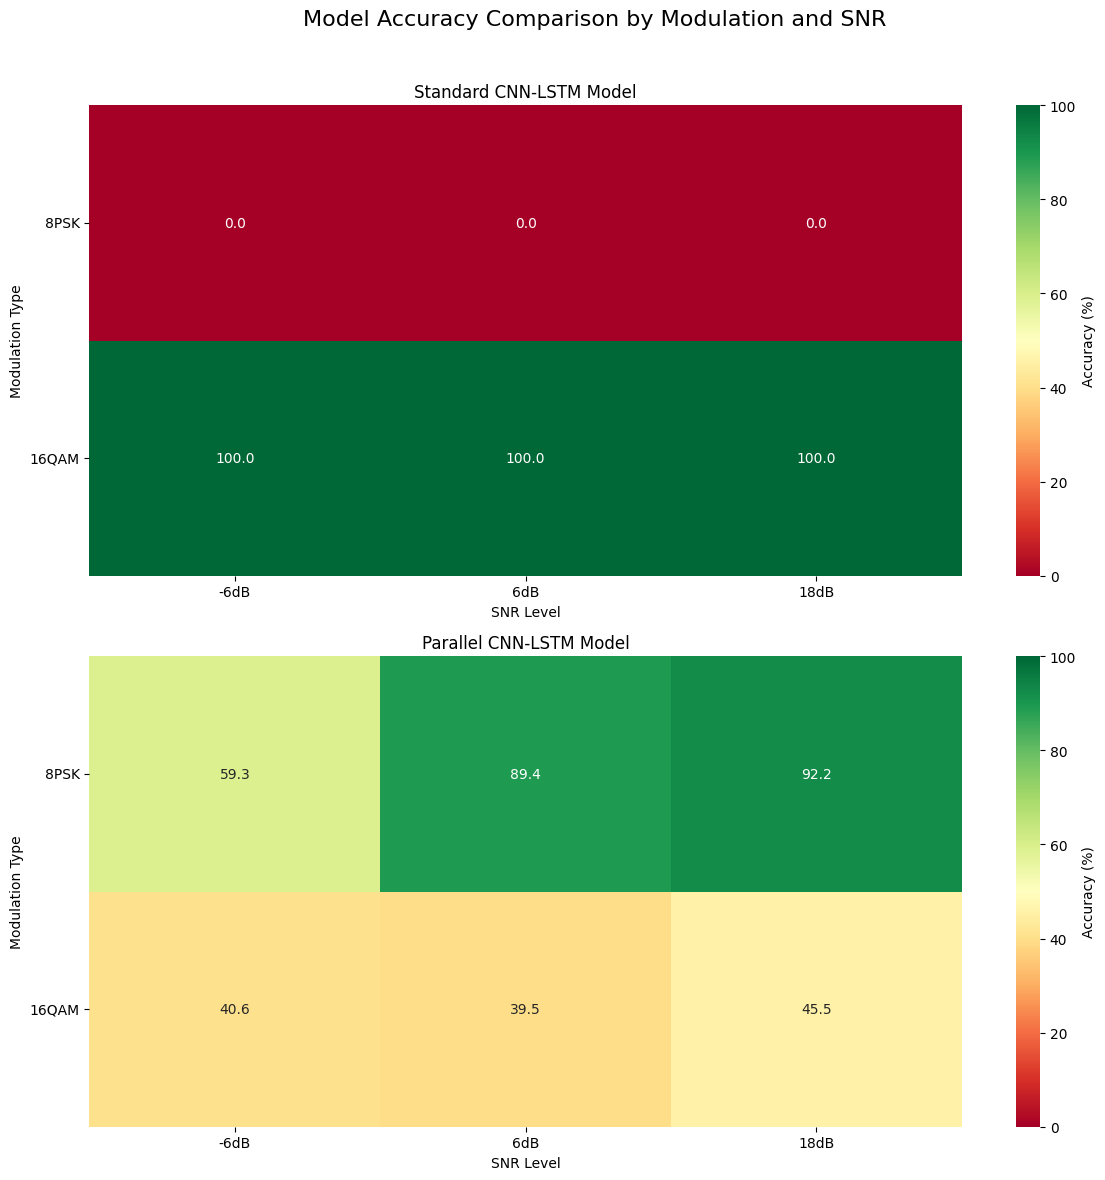

In [ ]:
def plot_modulation_snr_accuracy_heatmap_comparison(model1, model2, model1_name, model2_name, dataloader, device, target_modulations, target_snrs):
    models = {model1_name: model1, model2_name: model2}
    
    # Create figure with 2 subplots (one for each model)
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))
    fig.suptitle('Model Accuracy Comparison by Modulation and SNR', fontsize=16)
    
    for ax, (model_name, model) in zip(axes, models.items()):
        model.eval()
        all_preds = []
        all_labels = []
        all_snrs = []
        
        # Collect all predictions, labels, and SNRs from the validation set
        with torch.no_grad():
            for magnitude, phase, labels, snrs in dataloader:
                magnitude, phase = magnitude.to(device), phase.to(device)
                
                outputs = model(magnitude, phase)
                _, predicted = torch.max(outputs, 1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_snrs.extend(snrs.numpy())

        # Create a DataFrame for easy analysis
        results_df = pd.DataFrame({
            'true_label': all_labels,
            'predicted_label': all_preds,
            'snr': all_snrs
        })
        results_df['correct'] = (results_df['true_label'] == results_df['predicted_label'])

        # Create the accuracy matrix using a pivot table
        accuracy_matrix_df = pd.pivot_table(
            results_df, 
            values='correct', 
            index='true_label', 
            columns='snr', 
            aggfunc='mean'
        )
        
        # Convert to percentage
        accuracy_matrix = accuracy_matrix_df.values * 100
        
        # Plot the heatmap
        sns.heatmap(
            accuracy_matrix, 
            xticklabels=[f'{snr}dB' for snr in sorted(target_snrs)],
            yticklabels=target_modulations,
            annot=True, 
            fmt='.1f', 
            cmap='RdYlGn',
            vmin=0, 
            vmax=100,
            cbar_kws={'label': 'Accuracy (%)'},
            ax=ax
        )
        
        ax.set_title(f'{model_name} Model')
        ax.set_xlabel('SNR Level')
        ax.set_ylabel('Modulation Type')
        ax.tick_params(axis='y', rotation=0)

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
    plt.show()

plot_modulation_snr_accuracy_heatmap_comparison(
    model1=model_standard,
    model2=model_parallel,
    model1_name='Standard CNN-LSTM',
    model2_name='Parallel CNN-LSTM',
    dataloader=valid_loader,
    device=device,
    target_modulations=TARGET_MODULATIONS,
    target_snrs=TARGET_SNRS
)

In [ ]:
# class RadioMLWaveletDataset(Dataset):
#     """Dataset class for RadioML18 data with Wavelet Transform for CNNIQModel dual-branch architecture.
    
#     Loads RadioML18 HDF5 data and applies wavelet transforms to return 2D time-frequency
#     representations suitable for CNN processing.
#     """
    
#     def __init__(self, mode: str, use_complex_wavelet: bool = True, wavelet_name: str = 'cmor1.5-1.0', 
#                  num_scales: int = 64, seed: int = 48):
#         """Initialize RadioMLWaveletDataset.
        
#         Args:
#             mode: Dataset split mode ('train', 'valid', or 'test').
#             use_complex_wavelet: Whether to use complex wavelets (True) or real wavelets (False).
#             wavelet_name: Wavelet type ('cmor1.5-1.0', 'morl', 'db4', etc.).
#             num_scales: Number of wavelet scales to use.
#             seed: Random seed for dataset splitting.
            
#         Raises:
#             FileNotFoundError: If HDF5 or JSON files cannot be found.
#             ValueError: If mode is not valid or data dimensions are incompatible.
#         """
#         super(RadioMLWaveletDataset, self).__init__()
        
#         # Configuration - you'll need to define these constants
#         self.file_path = FILE_PATH 
#         self.json_path = JSON_PATH 
#         self.target_modulations = TARGET_MODULATIONS
#         self.use_complex_wavelet = use_complex_wavelet
#         self.wavelet_name = wavelet_name
#         self.num_scales = num_scales
#         self.mode = mode
        
#         # Validate mode
#         if mode not in ['train', 'valid', 'test']:
#             raise ValueError(f"Mode must be 'train', 'valid', or 'test', got '{mode}'")
        
#         # Load data files
#         try:
#             self.hdf5_file = h5py.File(self.file_path, 'r')
#             self.modulation_classes = json.load(open(self.json_path, 'r'))
#         except FileNotFoundError as e:
#             raise FileNotFoundError(f"Error loading data files: {e}")
#         except Exception as e:
#             print(f"Error loading file: {e}")
#             raise e
        
#         # Load raw data
#         self.X = self.hdf5_file['X']
#         self.Y = np.argmax(self.hdf5_file['Y'], axis=1)
#         self.Z = self.hdf5_file['Z'][:, 0]
        
#         # Fix the proportion calculation
#         num_mods = len(self.target_modulations)   
#         self.target_snrs = np.unique(self.Z)
#         num_snrs = len(self.target_snrs)
        
#         # Use proper proportions instead of the broken nf_train logic
#         train_proportion = 0.7
#         valid_proportion = 0.2  
#         test_proportion = 0.1
        
#         # Split dataset
#         self.X_data, self.Y_data, self.Z_data = self.dataset_split(
#             data=self.X,
#             modulations_classes=self.modulation_classes,
#             modulations=self.Y,
#             snrs=self.Z,
#             mode=mode,
#             train_proportion=train_proportion,
#             valid_proportion=valid_proportion,
#             test_proportion=test_proportion,
#             target_modulations=self.target_modulations,
#             target_snrs=self.target_snrs,
#             seed=seed
#         )
        
#         # Apply I/Q channel ordering
#         print(f"🔧 Applying I/Q channel ordering for {mode} dataset...")
#         self.X_data = self.X_data[:, :, [0, 1]]
#         print(f"✅ I/Q channels ordered correctly")
        
#         # Validate signal length
#         self.signal_length = self.X_data.shape[1]
#         if self.signal_length != 1024:
#             print(f"⚠️  Expected signal length 1024, got {self.signal_length}")
        
#         # Setup wavelet scales
#         self.scales = np.logspace(0, np.log10(self.signal_length//4), self.num_scales)
        
#         # Calculate 2D dimensions for wavelet coefficients
#         # For CWT: (num_scales, signal_length) → need to reshape for CNN
#         self.setup_wavelet_dimensions()
        
#         print(f"🌊 Wavelet Transform Configuration:")
#         print(f"   Wavelet: {self.wavelet_name}")
#         print(f"   Scales: {self.num_scales} (from {self.scales[0]:.1f} to {self.scales[-1]:.1f})")
#         print(f"   Complex: {self.use_complex_wavelet}")
#         print(f"   Output shape: (1, {self.H}, {self.W})")
        
#         # Store dataset statistics
#         self.num_data = self.X_data.shape[0]
#         self.num_lbl = len(self.target_modulations)
#         self.num_snr = len(self.target_snrs)
        
#         print(f"RadioMLWaveletDataset {mode}: {self.num_data} samples, "
#               f"{self.num_lbl} classes, {self.num_snr} SNR levels")
    
#     def setup_wavelet_dimensions(self):
#         """Calculate optimal 2D dimensions for wavelet coefficient matrix."""
#         # Wavelet coefficients will be (num_scales, signal_length)
#         total_elements = self.num_scales * self.signal_length
        
#         # Find good 2D dimensions that preserve most information
#         # Option 1: Keep scales as height, downsample time
#         if self.signal_length >= self.num_scales:
#             # Downsample time dimension to make it square-ish
#             time_downsample = self.signal_length // self.num_scales
#             self.H = self.num_scales
#             self.W = self.signal_length // time_downsample
#         else:
#             # If more scales than time samples, use different approach
#             self.H = self.num_scales
#             self.W = self.signal_length
        
#         # Alternative: Force square dimensions
#         sqrt_total = int(math.sqrt(total_elements))
#         self.H_alt = sqrt_total
#         self.W_alt = total_elements // sqrt_total
        
#         # Use the scale-preserving approach by default
#         print(f"🔧 Wavelet coefficients: ({self.num_scales}, {self.signal_length}) → reshape to ({self.H}, {self.W})")
    
#     def dataset_split(self, data, modulations_classes, modulations, snrs,
#                      target_modulations, mode, target_snrs,
#                      train_proportion=0.7, valid_proportion=0.2, test_proportion=0.1,
#                      seed=48):
#         """Split dataset into train/valid/test sets."""
#         np.random.seed(seed)
#         X_output = []
#         Y_output = []
#         Z_output = []
        
#         target_modulation_indices = [modulations_classes.index(modu) for modu in target_modulations]
        
#         for modu in target_modulation_indices:
#             for snr in target_snrs:
#                 snr_modu_indices = np.where((modulations == modu) & (snrs == snr))[0]
#                 np.random.shuffle(snr_modu_indices)
#                 num_samples = len(snr_modu_indices)
                
#                 train_end = int(train_proportion * num_samples)
#                 valid_end = int((train_proportion + valid_proportion) * num_samples)
                
#                 if mode == 'train':
#                     indices = snr_modu_indices[:train_end]
#                 elif mode == 'valid':
#                     indices = snr_modu_indices[train_end:valid_end]
#                 elif mode == 'test':
#                     indices = snr_modu_indices[valid_end:]
#                 else:
#                     raise ValueError(f'Unknown mode: {mode}')
                
#                 if len(indices) > 0:
#                     X_output.append(data[np.sort(indices)])
#                     Y_output.append(modulations[np.sort(indices)])
#                     Z_output.append(snrs[np.sort(indices)])
        
#         X_array = np.vstack(X_output)
#         Y_array = np.concatenate(Y_output)
#         Z_array = np.concatenate(Z_output)
        
#         # Remap labels to consecutive integers
#         for index, value in enumerate(np.unique(np.copy(Y_array))):
#             Y_array[Y_array == value] = index
        
#         return X_array, Y_array, Z_array
    
#     def __len__(self) -> int:
#         """Return the number of samples in the dataset."""
#         return self.X_data.shape[0]
    
#     def apply_wavelet_transform(self, i_signal: np.ndarray, q_signal: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
#         """Apply wavelet transform to I/Q signals.
        
#         Args:
#             i_signal: In-phase component (1D array)
#             q_signal: Quadrature component (1D array)
            
#         Returns:
#             Tuple of two 2D arrays for dual-branch CNN processing
#         """
#         if self.use_complex_wavelet:
#             # Combine I/Q into complex signal
#             complex_signal = i_signal + 1j * q_signal
            
#             # Apply complex wavelet transform
#             coefficients, frequencies = pywt.cwt(complex_signal, self.scales, self.wavelet_name)
            
#             # Extract magnitude and phase
#             magnitude = np.abs(coefficients)
#             phase = np.angle(coefficients)
            
#             # Reshape to target dimensions
#             magnitude_2d = self.reshape_coefficients(magnitude)
#             phase_2d = self.reshape_coefficients(phase)
            
#             return magnitude_2d, phase_2d
            
#         else:
#             # Apply real wavelet transform to I and Q separately
#             if 'cmor' in self.wavelet_name:
#                 # Complex Morlet wavelets need complex input, use 'morl' for real
#                 wavelet_real = 'morl'
#             else:
#                 wavelet_real = self.wavelet_name
            
#             # Transform I and Q channels separately
#             coeffs_i, _ = pywt.cwt(i_signal, self.scales, wavelet_real)
#             coeffs_q, _ = pywt.cwt(q_signal, self.scales, wavelet_real)
            
#             # Reshape to target dimensions
#             i_2d = self.reshape_coefficients(coeffs_i)
#             q_2d = self.reshape_coefficients(coeffs_q)
            
#             return i_2d, q_2d
    
#     def reshape_coefficients(self, coeffs: np.ndarray) -> np.ndarray:
#         """Reshape wavelet coefficients to target 2D dimensions."""
#         # coeffs shape: (num_scales, signal_length)
        
#         # Method 1: Downsample time dimension if needed
#         if coeffs.shape[1] > self.W:
#             # Downsample time dimension
#             step = coeffs.shape[1] // self.W
#             coeffs_resized = coeffs[:, ::step][:, :self.W]
#         else:
#             coeffs_resized = coeffs
        
#         # Pad or crop to exact dimensions
#         if coeffs_resized.shape[0] > self.H:
#             coeffs_resized = coeffs_resized[:self.H, :]
#         elif coeffs_resized.shape[0] < self.H:
#             pad_height = self.H - coeffs_resized.shape[0]
#             coeffs_resized = np.pad(coeffs_resized, ((0, pad_height), (0, 0)), mode='constant')
        
#         if coeffs_resized.shape[1] > self.W:
#             coeffs_resized = coeffs_resized[:, :self.W]
#         elif coeffs_resized.shape[1] < self.W:
#             pad_width = self.W - coeffs_resized.shape[1]
#             coeffs_resized = np.pad(coeffs_resized, ((0, 0), (0, pad_width)), mode='constant')
        
#         return coeffs_resized
    
#     def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, int, float]:
#         """Get a single sample with wavelet transform applied.
        
#         Args:
#             idx: Sample index
            
#         Returns:
#             Tuple of (tensor1, tensor2, label, snr) where:
#             - tensor1, tensor2: 2D wavelet transform tensors for dual-branch CNN
#             - label: Modulation class label  
#             - snr: Signal-to-noise ratio
#         """
#         if idx < 0 or idx >= self.num_data:
#             raise IndexError(f"Index {idx} out of range for dataset of size {self.num_data}")

#         x_raw = self.X_data[idx]       # shape: (L, 2)
#         y = int(self.Y_data[idx])
#         z = float(self.Z_data[idx])

#         # Extract I and Q components
#         i_signal = x_raw[:, 0]  # I component
#         q_signal = x_raw[:, 1]  # Q component
        
#         # Apply wavelet transform
#         wavelet_1, wavelet_2 = self.apply_wavelet_transform(i_signal, q_signal)
        
#         # Convert to tensors and add channel dimension
#         tensor_1 = torch.from_numpy(wavelet_1).float().unsqueeze(0)  # (1, H, W)
#         tensor_2 = torch.from_numpy(wavelet_2).float().unsqueeze(0)  # (1, H, W)
        
#         return tensor_1, tensor_2, y, z
    
#     def get_signal_stats(self):
#         """Compute basic stats over a sample of wavelet-transformed signals."""
#         sample_indices = np.random.choice(self.num_data, min(100, self.num_data), replace=False)
#         tensor1_vals, tensor2_vals = [], []
        
#         for idx in sample_indices:
#             t1, t2, _, _ = self[idx]
#             tensor1_vals.append(t1.flatten())
#             tensor2_vals.append(t2.flatten())
        
#         t1_all = torch.cat(tensor1_vals)
#         t2_all = torch.cat(tensor2_vals)
        
#         return {
#             'wavelet_type': self.wavelet_name,
#             'complex_wavelet': self.use_complex_wavelet,
#             'tensor1_mean': t1_all.mean().item(),
#             'tensor1_std': t1_all.std().item(),
#             'tensor1_min': t1_all.min().item(),
#             'tensor1_max': t1_all.max().item(),
#             'tensor2_mean': t2_all.mean().item(),
#             'tensor2_std': t2_all.std().item(),
#             'tensor2_min': t2_all.min().item(),
#             'tensor2_max': t2_all.max().item(),
#             'shape': (1, self.H, self.W),
#             'num_samples': self.num_data,
#             'num_scales': self.num_scales,
#             'signal_length': self.signal_length
#         }
    
#     def get_class_distribution(self):
#         """Get the distribution of classes in the dataset."""
#         unique, counts = np.unique(self.Y_data, return_counts=True)
#         class_names = [self.target_modulations[i] for i in unique if i < len(self.target_modulations)]
#         return dict(zip(class_names, counts[:len(class_names)]))
    
#     def close(self):
#         """Close HDF5 file handle."""
#         if hasattr(self, 'hdf5_file'):
#             self.hdf5_file.close()

#     def __del__(self):
#         """Destructor to ensure file cleanup."""
#         self.close()